# **Preprocessing and Feature Selection of scRNA-Seq Data**

We first need to import relevant modules.

In [51]:
import numpy as np
import pandas as pd
import nvr
import matplotlib.pyplot as plt
%matplotlib inline

Next, upload UMI/counts from the data directory into a pandas Dataframe. 

In [52]:
raw = pd.read_csv( "../data/raw_scRNA.csv")

Its always a good idea to check your data has been loaded correctly.

In [53]:
raw.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,0,4,4,0,0,0,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4,3,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
num_cells, num_genes = raw.shape
print( "Number of cells = {0}...........Number of genes = {1}".format( num_cells, num_genes))

Number of cells = 3000...........Number of genes = 38487


## **Filter Cells Based Mitochondrial Counts and Library Size**

Identify mitochondrial (mito) genes by searching for genes that start with 'mt'. Naming conventions vary 'mt' or 'Mt', so typically look for `mt-Atp6`. 

In [55]:
count_names = raw.columns

In [56]:
mt_mask = pd.Series( count_names).str.startswith( 'mt').values # startswith() is case sensitive
count_names.values[mt_mask]

array(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5',
       'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te',
       'mt-Tf', 'mt-Tg', 'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2',
       'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2',
       'mt-Tt', 'mt-Tv', 'mt-Tw', 'mt-Ty'], dtype=object)

Now we want to get the percentage of mito genes for each cell, cells with high mito expression are often dead or dying cells. You may **not** want to do this depending on your tissue/cell types (cancer cells, etc)

In [57]:
# get summed mito counts for each cell
cell_mt_sum = np.sum( raw.iloc[:,mt_mask].values, axis=1)
# get summed counts for all genes
lib_sizes   = np.sum( raw.values, axis=1)
pert_mito   = cell_mt_sum/lib_sizes.astype(float)*100

Text(0,0.5,'Fequency')

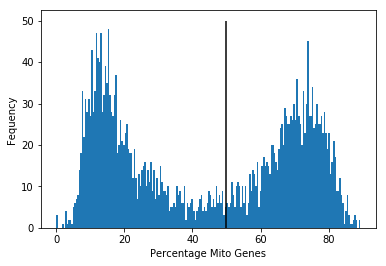

In [58]:
plt.vlines( 50, 0, 50)
_=plt.hist( pert_mito, bins=200)
plt.xlabel("Percentage Mito Genes")
plt.ylabel("Fequency")

The cutoff for dead/alive based and mito percentage is subjective and will vary based on the biology. Here we use a cuttoff of 50% mito genes. 

In [59]:
alive_counts = raw.iloc[pert_mito<=50,:]

It should be noted, an alternate way of removing dead cells by gating on a PCA, t-SNE, or UMAP.

Next we screen cells based on their library size. First, calculate the library size (total number of counts) for all cells and sort the sizes from highest to lowest.

In [60]:
sort_lib_sizes = np.sort( np.sum( alive_counts.values, axis=1))[::-1] # [::-1] reverses the array order so that its highest to lowest

A histogram of library sizes shows that most of these cells have very few gene counts, so we need to remove these cells.

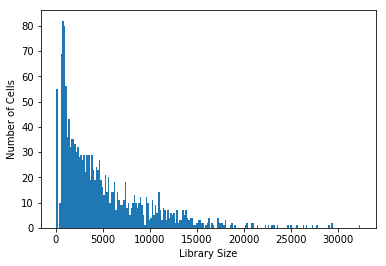

In [12]:
plt.hist( sort_lib_sizes, bins=200)
plt.ylabel('Number of Cells')
_ = plt.xlabel('Library Size')

There are a few ways to accomplish this, but we prefer cumulative sum plotting. We start by first plotting the cumulative sum of the sorted cell library sizes, where cumulative sum of an *`array(a,b,c)`* equals *`(a, a+b, a+b+c)`*. We sorted or library sizes highest to lowest, so in our case *`a>b>c`*.

In [13]:
# simple example of np.cumsum()
np.cumsum( [6,4,1])

array([ 6, 10, 11])

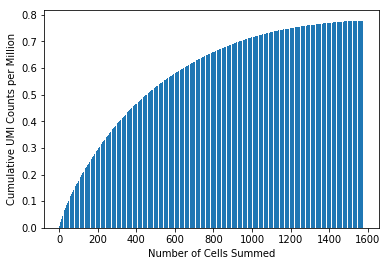

In [14]:
plt.bar( np.arange( alive_counts.shape[0]), np.cumsum( sort_lib_sizes)/1e7)
plt.ylabel( 'Cumulative UMI Counts per Million')
_ = plt.xlabel( 'Number of Cells Summed')

Cells with smaller library sizes will contribute less to the cumulative sum than cells with larger library sizes. Cells after the inflection point are considered "bad" due to their small library sizes. This cutoff changes dataset to dataset depending upon the platform, sequencing dept, biology, and etc.

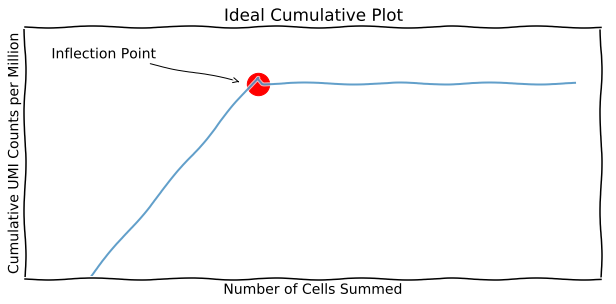

In [50]:
with plt.xkcd():
    fig = plt.figure( figsize=(10,5))
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    plt.xticks([])
    plt.yticks([])
    ax.set_ylim([-30, 10])
    data = np.ones(100) 
    data[:40] -= np.arange(40)[::-1] - 1
    plt.annotate( 'Inflection Point', xy=(36, 1.2), arrowprops=dict(arrowstyle='->'), xytext=(-0, 5))
    plt.plot(data, alpha=0.7)
    plt.scatter( 39, 1, c='red', s=500)
    plt.xlabel('Number of Cells Summed')
    plt.ylabel('Cumulative UMI Counts per Million')
    plt.title('Ideal Cumulative Plot')

Again, this is very much a subjective exercise. For that reason, we under estimate the inflection point to be more restrictive. Here, we estimate it to be ~900.

In [61]:
inflect_pt = 700

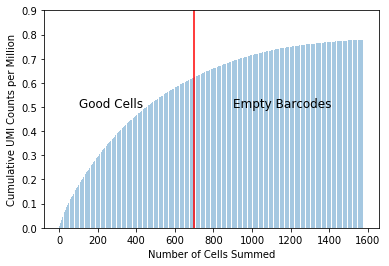

In [62]:
plt.bar( np.arange( alive_counts.shape[0]), np.cumsum( sort_lib_sizes)/1e7, alpha=0.4)
plt.vlines( inflect_pt, 0, 0.9, colors='red')
plt.ylabel( 'Cumulative UMI Counts per Million')
plt.text( 100, 0.5, 'Good Cells', fontsize=12)
plt.text( 900, 0.5, 'Empty Barcodes', fontsize=12)
plt.ylim(0.0,0.9)
_ = plt.xlabel( 'Number of Cells Summed')

Good cells can now be selected for using our threshold. Since the library sizes were sorted from high to low we can pull the 700 cells with largest cell libraries using the `np.argsort()` function. Instead of returning the sorted values, `np.argsort()` returns an array of element indices that have been sorted on  values from lowest to highest.  

In [18]:
# simple np.argsort() example
np.argsort( [5,1,2])

array([1, 2, 0])

In [19]:
np.argsort( sort_lib_sizes)

array([1579, 1578, 1577, ...,    2,    1,    0])

Sort functions rank from lowest to highest so we want the last 700 cell indices.

In [20]:
good_ind = np.argsort( sort_lib_sizes)[-inflect_pt:]

Select good cells from raw count data. 

In [21]:
good_cells = alive_counts.iloc[good_ind,:]
good_cells.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
701,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
696,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
good_cells.shape

(700, 38487)

## **Filter Genes**

To filter out genes we start by removing genes with only 0 or 1 as entry.

In [23]:
# for speed purposes create ndarray from good_cells Dataframe
good_vals = good_cells.values
# create an array to hold good gene indices
good_gene_ind = np.array( [], dtype=int)
for ii in range( num_genes):
    # get the unique values for column index ii
    unique_vals = np.unique( good_vals[:,ii])
    # test if the sum of unique values is less than or equal to 1
    if( unique_vals.sum()>1):
        # if so record the column index
        good_gene_ind = np.append( good_gene_ind, ii)

In [24]:
exp_genes = good_cells.iloc[:,good_gene_ind]
exp_genes.head()

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,0610037L13Rik,...,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6,mt-Rnr1,mt-Rnr2
701,1,0,0,0,0,1,0,1,0,0,...,71,95,71,15,107,1,12,0,12,19
700,0,0,0,0,0,0,0,0,0,0,...,106,97,60,48,117,1,11,0,6,2
699,1,0,0,0,0,0,0,0,0,0,...,145,90,73,44,108,1,20,0,20,24
697,0,0,0,0,0,0,0,0,0,0,...,99,70,60,42,88,0,9,0,12,45
696,1,0,0,0,0,2,0,0,0,0,...,198,134,94,48,146,0,14,0,20,28


## **Remove Mitochondrial Genes**

In [25]:
exp_names = exp_genes.columns

Identify mitochondrial genes by searching for genes that start with 'mt'. Naming conventions vary 'mt' or 'Mt', so typically look for `mt-Atp6`. 

In [26]:
mt_mask = pd.Series( exp_names).str.startswith( 'mt').values # startswith() is case sensitive
exp_names.values[mt_mask]

array(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5',
       'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2'], dtype=object)

We can invert the mask using `~`.

In [27]:
# example of inverting a mask
print  mt_mask
print ~mt_mask

[False False False ...  True  True  True]
[ True  True  True ... False False False]


In [28]:
exp_names.values[~mt_mask]

array(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', ..., 'Zzz3',
       'a', 'l7Rn6'], dtype=object)

We now have a Dataframe filtered by both cells and genes. 

In [29]:
filt_genes = exp_genes.iloc[:,~mt_mask]
filt_genes.head()

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,0610037L13Rik,...,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
701,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
696,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## **Normalize for Cell Specific Biases**

Each cell sequenced is an individual experiment with different capture efficiency and sequencing depths, so we need to correct for cell-to-cell variations with normalization. We normalize cells by multiplying each entry by a constant scaling factor and divided by the library size for cell the count is assigned. More formally, for cell *i* and gene *j*,

$$ Norm Count_{ij} = Count_{ij} * \frac{Scaling Factor}{Library Size_{i}} $$

The scaling factor is used to return the count data to a quantities more resembling the raw count data. Here, we use the grand median of only good cell library sizes.

In [30]:
good_lib_sizes = np.sum( good_cells.values, axis=1)

In [31]:
grand_med = np.median( good_lib_sizes)
grand_med

7610.0

In [32]:
norm_array = grand_med / good_lib_sizes


In [33]:
norm_counts = np.zeros_like( filt_genes, dtype=float)
for ii in range( filt_genes.shape[1]):
    norm_counts[:,ii] = np.multiply( filt_genes.iloc[:,ii], norm_array)

## **Variance Normalization**

Count data is assumed to closely match a Poisson distribution, where the mean is equal to the variance, increasing as the mean increases. We can show that our data closely matches a Poisson distribution by plotting coefficient of variation (CV) vs log10( mean gene expression). CV is simply variance divided by the mean. The redline below is the trend our data would fit if the mean equaled the variance - Poisson distributed.

In [34]:
# coefficient of variation (CV) function
cv =  lambda x: np.var( x) / np.mean( x)

In [35]:
cvs = norm_counts.std(axis=0) / norm_counts.mean(axis=0)
cvp = np.sqrt( norm_counts.mean(axis=0)) / norm_counts.mean(axis=0)

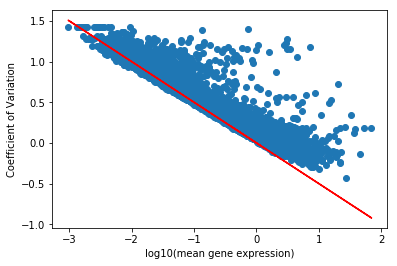

In [36]:
plt.scatter( np.log10( norm_counts.mean(axis=0)), np.log10( cvs))
plt.plot( np.log10( norm_counts.mean(axis=0)), np.log10( cvp), 'r')
plt.xlabel("log10(mean gene expression)")
_=plt.ylabel("Coefficient of Variation")

The problem with our data being Poisson distribution is downstream analysis assumes data is normally distributed. Any method using Euclidean distances implies normally distributed data (PCA, clustering, and etc). To make our data more "normalized" we need to normalize variances. We typically use an arcsinh with a cofacter of 5.0, but log2 and log10 (plus 1) is commonly used. 

In [37]:
arc_data = np.arcsinh( norm_counts/5.0)

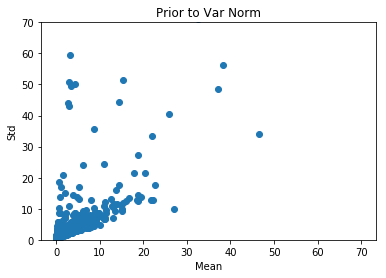

In [38]:
plt.scatter( np.mean( norm_counts, axis=0), np.std( norm_counts, axis=0))
plt.ylim(0,70)
plt.ylabel("Std")
plt.xlabel("Mean")
_=plt.title("Prior to Var Norm")

Text(0.5,1,'After arcsinh')

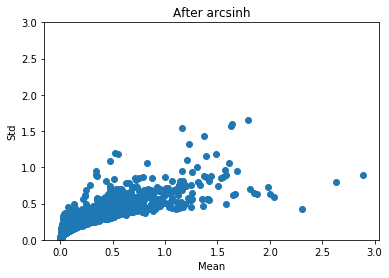

In [39]:
plt.scatter( np.mean( arc_data, axis=0), np.std( arc_data, axis=0))
plt.ylim(0,3.0)
plt.ylabel("Std")
plt.xlabel("Mean")
plt.title("After arcsinh")

## **Feature Selection with NVR**

Python implementation of NVR (neighborhood variance ratio) gene selection to select genes with local and monotonic variation ([Welch et al., 2016](https://www.ncbi.nlm.nih.gov/pubmed/27215581)). The selected genes possess specific expression patterns over the entire data space amenable to trajectory analysis. This is much faster than the R implementation, but will still take a while.

In [40]:
# nvr only takes numpy ndarray as input
type( arc_data)

numpy.ndarray

In [41]:
selected_genes = nvr.select_genes( arc_data)

Start min_conn_k
4 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 324.121046066 seconds
done


After NVR we are left with ~800 genes

In [46]:
len( selected_genes)

887

To save out filter data set we need to first convert it over to a Dataframe.

In [47]:
nvr_data = pd.DataFrame( arc_data[:,selected_genes], columns=exp_names[selected_genes])
nvr_data.head()

,1700028M03Rik,1810011O10Rik,2010106E10Rik,2010107G12Rik,2010109I03Rik,2200002D01Rik,2700097O09Rik,2810417H13Rik,4930539E08Rik,4931406C07Rik,...,Ywhae,Ywhaq,Zfp169,Zfp36,Zfp40,Zfp407,Zfp787,Zg16,Zswim5,Zzef1
0,0.000000,0.38144,0.0,0.38144,0.0,0.000000,0.000000,0.381440,0.0,0.000000,...,0.718169,1.229225,0.381440,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.00000,0.0,0.00000,0.0,0.677759,0.357746,0.000000,0.0,0.000000,...,0.947841,1.173331,0.000000,0.0,0.0,0.0,0.0,0.947841,0.0,0.000000
2,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,1.146950,0.0,0.346873,...,0.346873,1.763594,0.000000,0.0,0.0,0.0,0.0,0.346873,0.0,0.000000
3,0.411642,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.768745,0.0,0.000000,...,1.060086,0.411642,0.000000,0.0,0.0,0.0,0.0,0.411642,0.0,0.000000
4,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.348745,1.151524,0.0,0.000000,...,0.348745,0.000000,0.662236,0.0,0.0,0.0,0.0,0.000000,0.0,0.348745


In [48]:
nvr_data.shape

(700, 887)

In [49]:
nvr_data.to_csv( "../data/preprocessed_data.csv", index=None)

### **References**

https://dockflow.org/workflow/simple-single-cell/

http://www.nxn.se/valent/2017/11/16/droplet-scrna-seq-is-not-zero-inflated